# Classifying Fronts

## Largely by inspection at the moment

In [18]:
# imports
from importlib import reload
import os

import numpy as np
import h5py
import xarray
import pandas

from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import matplotlib.gridspec as gridspec
import seaborn as sns

from skimage import morphology

from wrangler.plotting import cutout
from wrangler.ogcm import llc as wr_llc

from fronts.dbof import utils as dbof_utils
from fronts.dbof import io as dbof_io

# DBOF_dev

In [9]:
dbof_dev_file = '../fronts/runs/dbof/dev/llc4320_dbof_dev.json'

In [34]:
def plot_example(field_data):

    # Plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    #cutout.show_image(sss, clbl='SSS (psu)', cm='viridis', ax=ax2)
    cutout.show_image(field_data['Divb2'], clbl=r'$\nabla b^2$', cm='Greys', ax=ax1)
    cutout.show_image(field_data['Fs'], clbl='Frontogenesis Tendency', ax=ax2)
    cutout.show_image(field_data['OW'], clbl='Okubo-Weiss', cm='viridis', ax=ax3)
    #
    plt.show()

# Load up

In [15]:
dbof_tbl = dbof_io.load_main_table(dbof_dev_file)

Read main table: /home/xavier/Oceanography/data/OGCM/DBOF/DBOF_dev/DBOF_dev.parquet


In [17]:
dbof_divb2_tbl = dbof_io.load_meta_table(dbof_dev_file, 'Divb2')

Read main table: /home/xavier/Oceanography/data/OGCM/DBOF/DBOF_dev/Fields/DBOF_dev_Divb2_meta.parquet


In [19]:
dbof_divb2_tbl.head()

,mx,mn,p10,p90,mu,gidx,tidx,UID,group
0,5.149910e-14,3.798008e-18,9.631537e-17,7.316145e-15,2.776794e-15,0,8,1317340146643510,2011-09-30T00
1,5.316743e-14,1.824944e-18,7.509030e-17,5.626106e-15,2.152494e-15,1,9,13173401466431510,2011-09-30T00
2,9.502109e-14,1.416877e-18,7.315746e-17,8.037236e-15,3.108352e-15,2,10,13173401466432510,2011-09-30T00
3,9.457798e-14,1.659967e-18,9.134431e-17,9.243041e-15,3.568747e-15,3,11,13173401466433490,2011-09-30T00
4,2.563670e-13,1.000785e-17,2.382297e-16,1.571945e-14,6.591412e-15,4,12,13173401466434490,2011-09-30T00


## Check

<Axes: xlabel='p90', ylabel='Count'>

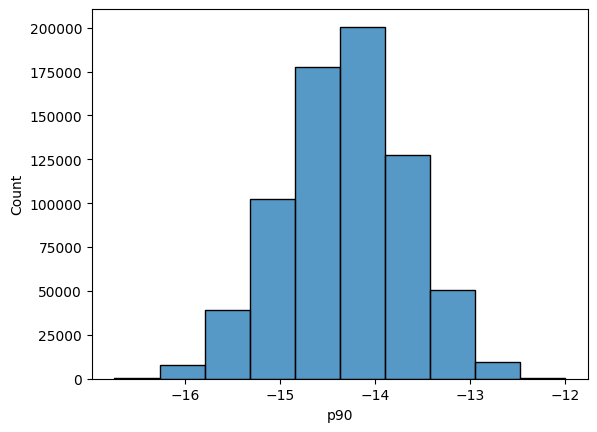

In [21]:
sns.histplot(np.log10(dbof_divb2_tbl.p90), bins=10)

# Try it

## Pick one

In [27]:
idx_14 = np.argmin(np.abs(dbof_divb2_tbl.p90-1e-14))
UID_14 = dbof_divb2_tbl.iloc[idx_14].UID
UID_14

np.int64(133315234509101135)

### Grab the field data

In [28]:
reload(dbof_utils)
field_data_14 = dbof_utils.grab_fields(dbof_dev_file, 'all', UID_14)

Grabbing fields for UID: 133315234509101135
/home/xavier/Oceanography/data/OGCM/DBOF/DBOF_dev/Fields/DBOF_dev_U_meta.parquet does not exist
Field U not found
Read main table: /home/xavier/Oceanography/data/OGCM/DBOF/DBOF_dev/Fields/DBOF_dev_V_meta.parquet
Read main table: /home/xavier/Oceanography/data/OGCM/DBOF/DBOF_dev/Fields/DBOF_dev_SSTK_meta.parquet
Read main table: /home/xavier/Oceanography/data/OGCM/DBOF/DBOF_dev/Fields/DBOF_dev_SSH_meta.parquet
Read main table: /home/xavier/Oceanography/data/OGCM/DBOF/DBOF_dev/Fields/DBOF_dev_SSS_meta.parquet
Read main table: /home/xavier/Oceanography/data/OGCM/DBOF/DBOF_dev/Fields/DBOF_dev_SSSs_meta.parquet
Read main table: /home/xavier/Oceanography/data/OGCM/DBOF/DBOF_dev/Fields/DBOF_dev_Fs_meta.parquet
Read main table: /home/xavier/Oceanography/data/OGCM/DBOF/DBOF_dev/Fields/DBOF_dev_Divb2_meta.parquet
Read main table: /home/xavier/Oceanography/data/OGCM/DBOF/DBOF_dev/Fields/DBOF_dev_OW_meta.parquet
Read main table: /home/xavier/Oceanography

In [29]:
field_data_14.keys()

dict_keys(['V', 'SSTK', 'SSH', 'SSS', 'SSSs', 'Fs', 'Divb2', 'OW', 'SSHs'])

### Plot it

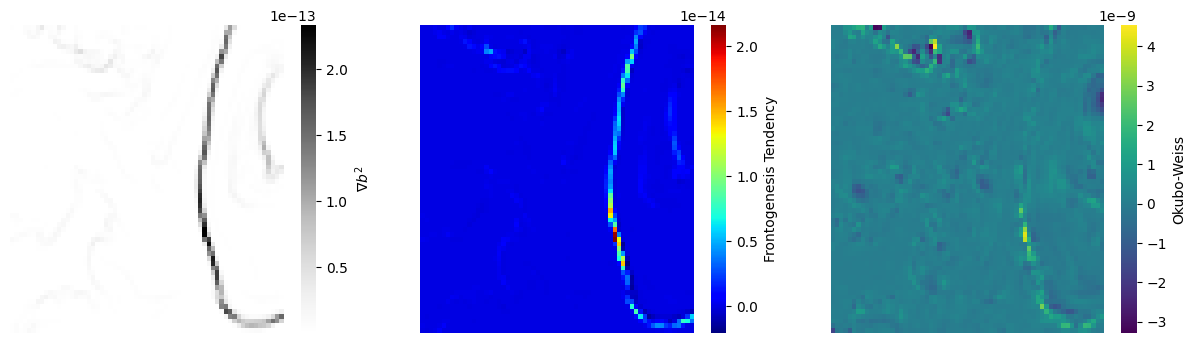

In [35]:
plot_example(field_data_14)

# Another one

In [36]:
idx_145 = np.argmin(np.abs(dbof_divb2_tbl.p90-3e-14))
UID_145 = dbof_divb2_tbl.iloc[idx_145].UID
field_data_145 = dbof_utils.grab_fields(dbof_dev_file, 'all', UID_145)

Grabbing fields for UID: 13279681798385414
Read main table: /home/xavier/Oceanography/data/OGCM/DBOF/DBOF_dev/Fields/DBOF_dev_U_meta.parquet
Read main table: /home/xavier/Oceanography/data/OGCM/DBOF/DBOF_dev/Fields/DBOF_dev_V_meta.parquet
Read main table: /home/xavier/Oceanography/data/OGCM/DBOF/DBOF_dev/Fields/DBOF_dev_SSTK_meta.parquet
Read main table: /home/xavier/Oceanography/data/OGCM/DBOF/DBOF_dev/Fields/DBOF_dev_SSH_meta.parquet
Field SSH not found for UID 13279681798385414
Read main table: /home/xavier/Oceanography/data/OGCM/DBOF/DBOF_dev/Fields/DBOF_dev_SSS_meta.parquet
Read main table: /home/xavier/Oceanography/data/OGCM/DBOF/DBOF_dev/Fields/DBOF_dev_SSSs_meta.parquet
Field SSSs not found for UID 13279681798385414
Read main table: /home/xavier/Oceanography/data/OGCM/DBOF/DBOF_dev/Fields/DBOF_dev_Fs_meta.parquet
Read main table: /home/xavier/Oceanography/data/OGCM/DBOF/DBOF_dev/Fields/DBOF_dev_Divb2_meta.parquet
Read main table: /home/xavier/Oceanography/data/OGCM/DBOF/DBOF_de

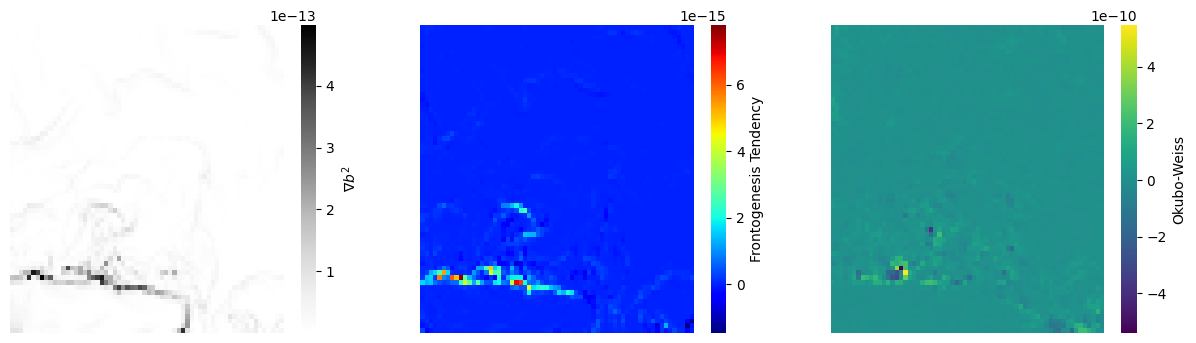

In [37]:
plot_example(field_data_145)

## One more

Grabbing fields for UID: 131734067008349448
Read main table: /home/xavier/Oceanography/data/OGCM/DBOF/DBOF_dev/Fields/DBOF_dev_U_meta.parquet
Read main table: /home/xavier/Oceanography/data/OGCM/DBOF/DBOF_dev/Fields/DBOF_dev_V_meta.parquet
Read main table: /home/xavier/Oceanography/data/OGCM/DBOF/DBOF_dev/Fields/DBOF_dev_SSTK_meta.parquet
Read main table: /home/xavier/Oceanography/data/OGCM/DBOF/DBOF_dev/Fields/DBOF_dev_SSH_meta.parquet
Read main table: /home/xavier/Oceanography/data/OGCM/DBOF/DBOF_dev/Fields/DBOF_dev_SSS_meta.parquet
Read main table: /home/xavier/Oceanography/data/OGCM/DBOF/DBOF_dev/Fields/DBOF_dev_SSSs_meta.parquet
Field SSSs not found for UID 131734067008349448
Read main table: /home/xavier/Oceanography/data/OGCM/DBOF/DBOF_dev/Fields/DBOF_dev_Fs_meta.parquet
Read main table: /home/xavier/Oceanography/data/OGCM/DBOF/DBOF_dev/Fields/DBOF_dev_Divb2_meta.parquet
Read main table: /home/xavier/Oceanography/data/OGCM/DBOF/DBOF_dev/Fields/DBOF_dev_OW_meta.parquet
Read main 

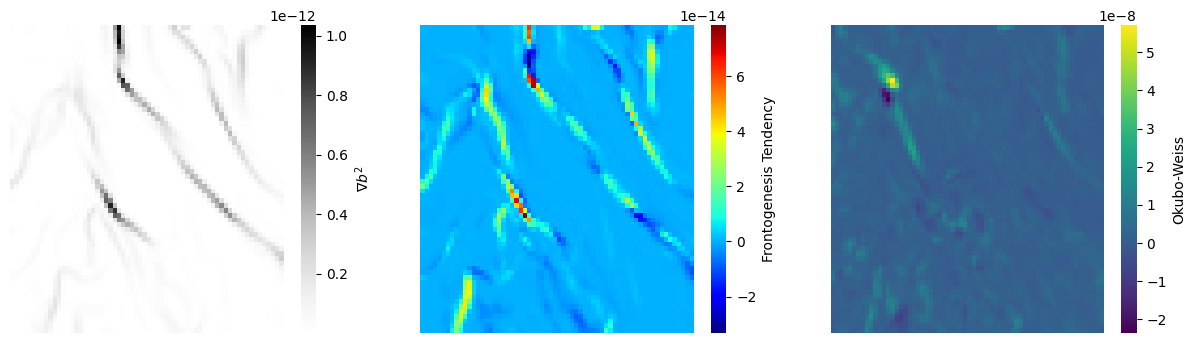

In [38]:
idx_13 = np.argmin(np.abs(dbof_divb2_tbl.p90-1e-13))
UID_13 = dbof_divb2_tbl.iloc[idx_13].UID
field_data_13 = dbof_utils.grab_fields(dbof_dev_file, 'all', UID_13)
plot_example(field_data_13)